In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.stats as ss
from scipy.interpolate import interp1d
from scipy.special import expit
from fractions import Fraction
from empiricaldist import Pmf, Cdf
import matplotlib.pyplot as plt
from collections import Counter
import statsmodels.formula.api as smfa

In [2]:
from data.utils import pmf_from_dist, plot_cdf, plot_pred

In [4]:
import pymc3 as pm
import arviz as az

In [5]:
alpha = 1.4
beta = 1
prior_dist = ss.gamma(alpha, scale=1/beta)

In [6]:
lams = np.linspace(0, 10, 101)
prior_pmf = pmf_from_dist(prior_dist, lams)
data = 4
likelihood = ss.poisson(lams).pmf(data)
posterior = prior_pmf * likelihood
posterior.normalize()
posterior

,probs
0.0,0.000000
0.1,0.000003
0.2,0.000053
0.3,0.000260
0.4,0.000755
...,...
9.6,0.000009
9.7,0.000008
9.8,0.000007
9.9,0.000006


<AxesSubplot:>

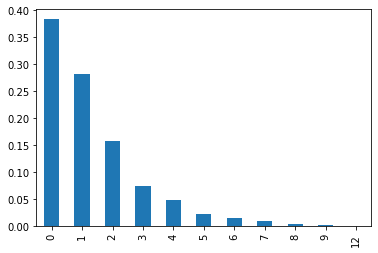

In [13]:
# 사전표본
sample_prior = prior_dist.rvs(1000)
# 사전표본에 대한 포아송 분포의 표본..? 이걸 책에서는 사전예측분포라고 표현
# rvs(mu, size=1) 메서드는 mu일 때 확률분포로 size만큼 생성
sample_prior_pred = ss.poisson.rvs(sample_prior)
pmf_prior_pred = Pmf.from_seq(sample_prior_pred)
pmf_prior_pred.plot.bar()

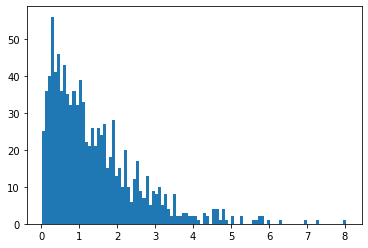

In [26]:
# 참고: 사전표본의 감마분포 확인을 위한 히스토그램 작업
sample_prior_copy = sample_prior.copy()
sample_prior_copy.sort()
plt.hist(sample_prior_copy, bins=100)
plt.show()

In [31]:
with pm.Model() as model:
    # 사전분포인 감마분포를 생성
    lam = pm.Gamma('lam', alpha=1.4, beta=1.0)
    # Poisson(mu=lam)을 가지는 사전예측분포 생성
    goals = pm.Poisson('goals', lam)

In [32]:
goals

goals ~ Poisson

In [35]:
with model:
    # 사전분포에서의 lam에 대한 표본..?
    # 위에서의 prior_dist(rvs)(trace['lam']) + ss.poisson.rvs(sample_prior)(trace['goal']와 같은 개념
    trace = pm.sample_prior_predictive(1000)

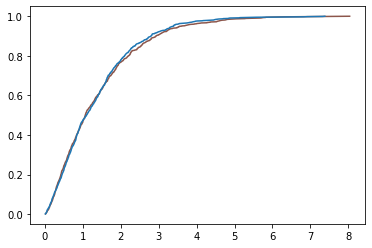

In [36]:
sample_prior_pymc = trace['lam']
plot_cdf(sample_prior, label='SciPy sample', color='C5')
plot_cdf(sample_prior_pymc, label='PyMC3 sample', color='C0')

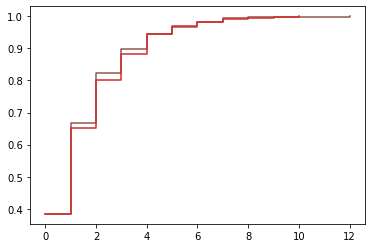

In [37]:
sample_prior_pred_pymc = trace['goals']
plot_pred(sample_prior_pred, label='SciPy sample', color='C5')
plot_pred(sample_prior_pred_pymc, label='PyMC3 sample', color='C13')

In [38]:
with pm.Model() as model2:
    # 사전분포인 감마분포를 생성
    lam = pm.Gamma('lam', alpha=1.4, beta=1.0)
    # observed 매개변수를 넣어 사후예측분포 생성
    goals = pm.Poisson('goals', lam, observed=4)

In [39]:
options = dict(return_inferencedata=False)
with model2:
    # 사후분포로부터 표본을 가져오는 형태
    # 1,000개의 표본에 대한 두 개의 값을 만든 후, 절반을 버리고 남은 1,000개를 반환
    trace2 = pm.sample(500, **options)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 23 seconds.


In [40]:
sample_post_pymc = trace2['lam']
sample_post_pymc.shape

(2000,)

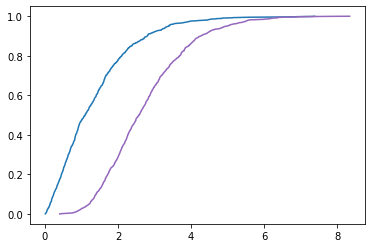

In [41]:
plot_cdf(sample_prior_pymc, label='PyMC3 sample', color='C0')
plot_cdf(sample_post_pymc, label='PyMC3 sample', color='C4')

In [42]:
with model2:
    # goals에 대한 사후표본을 가지고 예측한 분포?
    post_pred = pm.sample_posterior_predictive(trace2)

In [43]:
sample_post_pred_pymc = post_pred['goals']
sample_post_pred_pymc.shape

(2000,)

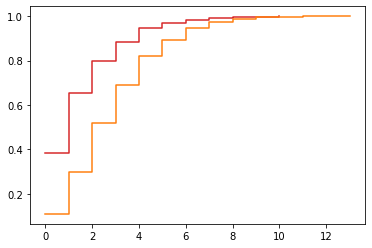

In [44]:
plot_pred(sample_prior_pred_pymc, label='PyMC3 sample', color='C13')
plot_pred(sample_post_pred_pymc, label='PyMC3 sample', color='C1')

In [46]:
filename = 'WHR20_DataForFigure2.1.xlsx'
df = pd.read_excel(Path.cwd() / 'data' / filename)

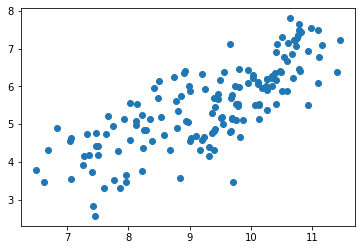

In [48]:
score = df['Ladder score']
log_gdp = df['Logged GDP per capita']
plt.scatter(x=log_gdp, y=score)

In [49]:
x_data = log_gdp
y_data = score

In [50]:
with pm.Model() as model3:
    # 사전분포로 균등분포를 깔아주고
    inter = pm.Uniform('inter', -3, 1)
    slope = pm.Uniform('slope', 0, 2)
    sigma = pm.Uniform('sigma', 0, 2)

    y_hat = inter + slope * x_data
    # observed를 넣어 사후분포 형태로 변환
    y = pm.Normal('y', mu=y_hat, sd=sigma, observed=y_data)

In [51]:
options = dict(return_inferencedata=False)
with model3:
    trace3 = pm.sample(500, **options)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\admin\AppData\Roaming\Python\Python310\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, slope, inter]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 594 seconds.


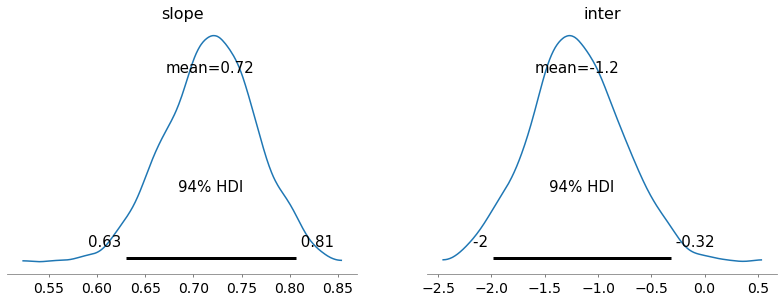

In [52]:
with model3:
    # arviz 라이브러리를 통해 사후분포의 분포도를 표현
    az.plot_posterior(trace3, var_names=['slope', 'inter'])

In [53]:
columns = ['Ladder score',
           'Logged GDP per capita',
           'Social support',
           'Healthy life expectancy',
           'Freedom to make life choices',
           'Generosity',
           'Perceptions of corruption']
subset = df[columns]

In [54]:
# 데이터의 표준화 진행
standardized = (subset - subset.mean()) / subset.std()

In [55]:
y_data = standardized['Ladder score']
x1 = standardized[columns[1]]
x2 = standardized[columns[2]]
x3 = standardized[columns[3]]
x4 = standardized[columns[4]]
x5 = standardized[columns[5]]
x6 = standardized[columns[6]]

In [56]:
with pm.Model() as model4:
    b0 = pm.Uniform('inter', -4, 4)
    b1 = pm.Uniform('b1', -4, 4)
    b2 = pm.Uniform('b2', -4, 4)
    b3 = pm.Uniform('b3', -4, 4)
    b4 = pm.Uniform('b4', -4, 4)
    b5 = pm.Uniform('b5', -4, 4)
    b6 = pm.Uniform('b6', -4, 4)
    sigma = pm.Uniform('sigma', 0, 2)

    y_hat = b0 + b1*x1 + b2*x2 + b3*x3 + b4*x4 + b5*x5 + b6*x6
    y = pm.Normal('y', mu=y_hat, sd=sigma, observed=y_data)

In [57]:
options = dict(return_inferencedata=False)
with model4:
    trace4 = pm.sample(500, **options)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\admin\AppData\Roaming\Python\Python310\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b6, b5, b4, b3, b2, b1, inter]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1458 seconds.


In [58]:
param_names = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6']
means = [round(trace4[name].mean(), 3) for name in param_names]
means

[0.247, 0.297, 0.224, 0.188, 0.056, -0.098]

In [59]:
def credible_interval(sample):
    ci = np.percentile(sample, [3, 97])
    return np.round(ci, 3)

cis = [credible_interval(trace4[name]) for name in param_names]
cis

[array([0.079, 0.41 ]),
 array([0.16 , 0.427]),
 array([0.071, 0.384]),
 array([0.094, 0.286]),
 array([-0.03 ,  0.146]),
 array([-0.194, -0.004])]